In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import ttpp

sns.set_style('whitegrid')

%matplotlib inline

In [2]:
def bench_training(model, batch_size, seq_length, n_samples=110):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    timings = []
    
    device = next(model.parameters()).data.device
    data = torch.rand(batch_size, seq_length, 1, device=device).cumsum(-1)
    mask = torch.ones_like(data)
        
    for _ in range(n_samples):
        start.record()
        nll = -model.log_prob(data, mask).mean()/seq_length
        end.record()
        torch.cuda.synchronize()
        timings.append(start.elapsed_time(end))
    del data
    del mask
    return np.array(timings)

def bench_sampling(model, batch_size, seq_length, n_samples=110):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    timings = []
    
    device = next(model.parameters()).data.device
    with torch.no_grad():
        for _ in range(n_samples):
            start.record()
            samples = model.rsample_n(batch_size, seq_length)
            end.record()
            torch.cuda.synchronize()
            timings.append(start.elapsed_time(end))
            del samples
    return np.array(timings)

In [3]:
config = {    
    'n_knots': 20,
    'n_splines': 1,
    'spline_order': 2,
    'use_jit': False,
    
    # For the TriTPP model
    'block_size': 16,
    'n_blocks': 4,
    
    # For the RNN model
    'hidden_size': 32,
}

In [4]:
batch_size = 100

In [5]:
train_results = dict()
sampling_results = dict()
lengths_list = [25, 50, 100, 200, 400, 800, 1600]
for model_type in ['TriTPP', 'Autoregressive']:
    model = getattr(ttpp.models, model_type)(100, **config).cuda()
    train_times = []
    sampling_times = []
    for seq_length in lengths_list:
        train_times.append(bench_training(model, batch_size, seq_length))
        sampling_times.append(bench_sampling(model, batch_size, seq_length))
        print(f"{model_type}, seq_length = {seq_length:4d}: train_time = {train_times[-1].mean():.2f}ms, sampling_time = {sampling_times[-1].mean():.2f}ms")
    train_times = np.array(train_times)
    sampling_times = np.array(sampling_times)
    train_results[model_type] = train_times
    sampling_results[model_type] = sampling_times
    del model

TriTPP, seq_length =   25: train_time = 11.42ms, sampling_time = 31.50ms
TriTPP, seq_length =   50: train_time = 9.79ms, sampling_time = 29.42ms
TriTPP, seq_length =  100: train_time = 9.80ms, sampling_time = 28.95ms
TriTPP, seq_length =  200: train_time = 9.86ms, sampling_time = 29.74ms
TriTPP, seq_length =  400: train_time = 9.88ms, sampling_time = 29.19ms
TriTPP, seq_length =  800: train_time = 10.03ms, sampling_time = 29.21ms
TriTPP, seq_length = 1600: train_time = 10.64ms, sampling_time = 29.96ms
Autoregressive, seq_length =   25: train_time = 3.81ms, sampling_time = 48.93ms
Autoregressive, seq_length =   50: train_time = 4.02ms, sampling_time = 97.20ms
Autoregressive, seq_length =  100: train_time = 4.63ms, sampling_time = 194.24ms
Autoregressive, seq_length =  200: train_time = 5.75ms, sampling_time = 389.21ms
Autoregressive, seq_length =  400: train_time = 8.09ms, sampling_time = 777.97ms
Autoregressive, seq_length =  800: train_time = 12.96ms, sampling_time = 1549.42ms
Autoreg

In [9]:
# The numbers printed above were collected as other jobs were running on this machine
# so they might not exactly match the correct numbers that can be seen in the paper

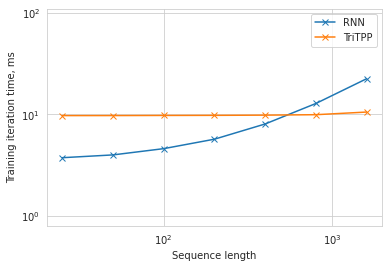

In [7]:
# Discard 10 slowest runtimes to remove the outliers (e.g. obtained during initialization)
tritpp_train_times = [np.mean(sorted(t)[:-10]) for t in train_results['TriTPP']]
rnn_train_times = [np.mean(sorted(t)[:-10]) for t in train_results['Autoregressive']]

plt.plot(lengths_list, rnn_train_times, label='RNN', marker='x')
plt.plot(lengths_list, tritpp_train_times, label='TriTPP', marker='x')
plt.loglog(True)
plt.legend()
plt.ylim(0.8, 110)
plt.xlabel('Sequence length')
plt.ylabel('Training iteration time, ms')
plt.show()

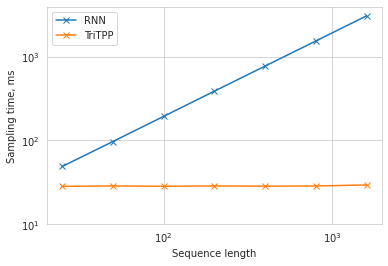

In [8]:
# Discard 10 slowest runtimes to remove the outliers (e.g. obtained during initialization)
tritpp_sampling_times = [np.mean(sorted(t)[:-10]) for t in sampling_results['TriTPP']]
rnn_sampling_times = [np.mean(sorted(t)[:-10]) for t in sampling_results['Autoregressive']]

plt.plot(lengths_list, rnn_sampling_times, label='RNN', marker='x')
plt.plot(lengths_list, tritpp_sampling_times, label='TriTPP', marker='x')
plt.loglog(True)
plt.legend()
plt.ylim(10, 4000)
plt.xlabel('Sequence length')
plt.ylabel('Sampling time, ms')
plt.show()